## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import plotly.express as px

import json
import os
import math
from statistics import mode

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, r2_score
import tensorflow.keras as keras
import keras
from keras.models import load_model
import pickle as pk

## Getting The Data

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets list -s gtzan
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!unzip /content/gtzan-dataset-music-genre-classification.zip

'''Librosa Not able to Load, hence delete :-
- Delete Jazz 54
- 
'''

## Plotting The Data

In [ ]:
data , sr = librosa.load('/content/Data/genres_original/blues/blues.00000.wav', sr = 45600)
data.shape

In [ ]:
plt.figure(figsize = (12, 4))
librosa.display.waveplot(data, color = "#502A75")
plt.show()

In [ ]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [ ]:
plt.figure(figsize = (14, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis = 'time', y_axis = 'log')
plt.colorbar()

In [ ]:
from sklearn.preprocessing import normalize
spectral_rolloff = librosa.feature.spectral_rolloff(data + 0.01, sr = sr)[0]
plt.figure(figsize = (12, 4))
librosa.display.waveplot(data, sr = sr, alpha = 0.4, color = "#2B4F72")

In [ ]:
plt.figure(figsize = (12, 4))
librosa.display.waveplot(data, sr = sr, color = "#2B4F72")

In [ ]:
n0 = 9000
n1 = 9100
plt.figure(figsize = (14, 5))
plt.plot(data[n0 : n1], color = "#2B4F72")
plt.grid()

## Reading The Data

In [ ]:
DATASET_PATH = "/content/genres_original"
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft = 2048, hop_length = 512, num_segments = 5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		            # load audio file
                file_path = os.path.join(dirpath, f)

                # try:
                # print('Dir Path', dirpath)
                # print('Dir Names', dirnames)
                print('Running:', file_path, 'Now')
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(semantic_label)
                        # print("{}, segment:{}".format(file_path, d+1))
                # except:
                #   pass

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
        
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

In [ ]:
# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "/content/data_10.json"

def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

### Labelling The Data

In [ ]:
X, y = load_data(DATA_PATH)

Data succesfully loaded!


In [ ]:
label = LabelEncoder()
y = label.fit_transform(y)

## Modelling

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label = "train accuracy")
    axs[0].plot(history.history["val_accuracy"], label = "test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

### Neural Network

In [ ]:
# # load data
# X, y = load_data(DATA_PATH)

# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# build network topology
model = keras.Sequential([
    # input layer
    keras.layers.Flatten(input_shape = (X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation = 'relu'),

    # 2nd dense layer
    keras.layers.Dense(256, activation = 'relu'),

    # 3rd dense layer
    keras.layers.Dense(64, activation = 'relu'),

    # output layer
    keras.layers.Dense(10, activation = 'softmax')
])

# compile model
optimiser = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = optimiser, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# model.summary()

# train model
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100)
plot_history(history)

#### Avoiding Overfitting

In [ ]:
# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# build network topology
model = keras.Sequential([
  # input layer
  keras.layers.Flatten(input_shape = (X.shape[1], X.shape[2])),

  # 1st dense layer
  keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
  keras.layers.Dropout(0.3),

  # 2nd dense layer
  keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
  keras.layers.Dropout(0.3),

  # 3rd dense layer
  keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
  keras.layers.Dropout(0.3),

  # output layer
  keras.layers.Dense(10, activation='softmax')
])

# compile model
optimiser = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimiser, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

# plot accuracy and error as a function of the epochs
plot_history(history)

### Convolution Networks

In [ ]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    # X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

Epoch 1/50
188/188 [==============================] - 11s 60ms/step - loss: 0.2787 - accuracy: 0.9065 - val_loss: 0.8543 - val_accuracy: 0.7356
Epoch 2/50
188/188 [==============================] - 11s 60ms/step - loss: 0.2904 - accuracy: 0.9027 - val_loss: 0.8117 - val_accuracy: 0.7377
Epoch 3/50
188/188 [==============================] - 11s 60ms/step - loss: 0.2669 - accuracy: 0.9127 - val_loss: 0.7982 - val_accuracy: 0.7530
Epoch 4/50
188/188 [==============================] - 11s 60ms/step - loss: 0.2814 - accuracy: 0.9062 - val_loss: 0.8153 - val_accuracy: 0.7363
Epoch 5/50
188/188 [==============================] - 12s 63ms/step - loss: 0.2737 - accuracy: 0.9045 - val_loss: 0.7838 - val_accuracy: 0.7543
Epoch 6/50
188/188 [==============================] - 15s 81ms/step - loss: 0.2612 - accuracy: 0.9124 - val_loss: 0.8171 - val_accuracy: 0.7377
Epoch 7/50
188/188 [==============================] - 11s 61ms/step - loss: 0.2658 - accuracy: 0.9124 - val_loss: 0.7994 - val_accuracy:

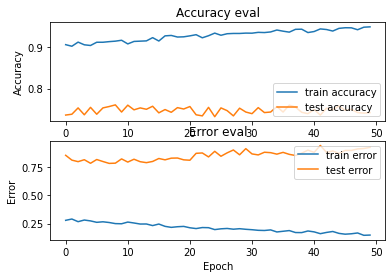

79/79 - 1s - loss: 1.0004 - accuracy: 0.7301

Test accuracy: 0.7300760746002197


In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# model.summary()

# train model
history = model.fit(X_train, y_train, validation_data = (X_validation, y_validation), batch_size = 32, epochs=50)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 2)
print('\nTest accuracy:', test_acc)

### RNN - LSTM

In [ ]:
def prepare_datasets(test_size, validation_size):
    # load data
    # X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape = input_shape, return_sequences = True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation = 'relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation = 'softmax'))

    return model

In [ ]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

# create network
input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = optimiser, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# model.summary()

# train model
history = model.fit(X_train, y_train, validation_data = (X_validation, y_validation), batch_size = 32, epochs = 100)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

## Saving Models

In [ ]:
# model.save('/content/drive/MyDrive/Deep Learning/best_model.h5')
# pk.dump(label, open('/content/drive/MyDrive/Deep Learning/le.pk', 'wb'))

## Testing With User Data

In [ ]:
def getUserInput(path, genre):
  samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

  user = {"labels": [], "mfcc": []}

  signal, sample_rate = librosa.load(path, sr = SAMPLE_RATE)

  # process all segments of audio file
  for d in range(num_segments):

      # calculate start and finish sample for current segment
      start = samples_per_segment * d
      finish = start + samples_per_segment

      # # extract mfcc
      if len(signal[start : finish]) == samples_per_segment:
        mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc = num_mfcc, 
                                    n_fft = n_fft, hop_length = hop_length)
        mfcc = mfcc.T

        # # store only mfcc feature with expected number of vectors
        if len(mfcc) == num_mfcc_vectors_per_segment:
            user["mfcc"].append(mfcc.tolist())
            user["labels"].append(genre)

  x_user = np.array(user['mfcc'])
  y_user = np.array(user['labels'])
  return x_user, y_user

In [ ]:
label.classes_

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype='<U9')

In [ ]:
SAMPLE_RATE = 22050
TRACK_DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
num_segments = 10
num_mfcc = 13
n_fft = 2048
hop_length = 512

path = '/content/drive/MyDrive/Deep Learning/Hurt Johnny Cash.wav'
recs = pd.read_csv('/content/drive/MyDrive/Deep Learning/Final Recs.csv')

# Loading the model and the label encoder
best_model = load_model('/content/drive/MyDrive/Deep Learning/best_model.h5')
le = pk.load(open('/content/drive/MyDrive/Deep Learning/le.pk', 'rb'))

# Get User Input
x_user, y_user = getUserInput(path, 'country')
print('File Uploaded:', 'hurt')
print('Class to be predicted: {}'.format('country'),' - ', le.transform(y_user)[0])

print(x_user.shape)
# If Using Conv2D Model
x_user = x_user[..., np.newaxis]
print(x_user.shape)

pred = np.argmax(best_model.predict(x_user), axis = -1)
genre = le.inverse_transform([mode(pred)])[0]

print('Class Actually Predicted:', genre, ' - ', mode(pred))

recommend = recs[recs['Genre'] == genre]

if recommend.shape[0] >= 3: sample = 3
else: sample = recommend.shape[0]

print('\nSong Recommendations For You Are:')
recommend.sample(sample)

File Uploaded: hurt
Class to be predicted: country  -  2
(10, 130, 13)
(10, 130, 13, 1)
Class Actually Predicted: country  -  2

Song Recommendations For You Are:


,Title,Artist,Top Genre,Year,Genre
186,Hurt,Johnny Cash,arkansas country,2002,country
1891,Tequila,Dan + Shay,contemporary country,2018,country
633,Jolene,Dolly Parton,classic country pop,1974,country


In [ ]:
recs.Genre.value_counts()

pop          855
rock         789
metal         93
classical     85
hiphop        43
blues         23
reggae        22
disco         18
country       15
jazz           3
Name: Genre, dtype: int64

In [ ]:
le.classes_

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype='<U9')

In [ ]:
type(recommend)

pandas.core.frame.DataFrame